## Simple MNIST classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(28*28, 300), 
            nn.Dropout(0.9),
            nn.Tanh())
        self.layer2 = nn.Sequential(
            nn.Linear(300, 300),
            nn.Tanh())
        self.layer3 = nn.Sequential(
            nn.Linear(300, 10)
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [3]:
net = Net()
x0 = torch.ones((28,28), requires_grad=True)
net(x0)

tensor([[ 0.1588,  0.1245,  0.0942, -0.1380, -0.1461,  0.0215, -0.0322, -0.0260,
          0.2012, -0.0899]], grad_fn=<AddmmBackward>)

In [4]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(5, 5, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(245, num_classes)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

In [5]:
# load dataset
tr = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

training_data = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=tr)
training_loader = torch.utils.data.DataLoader(training_data, batch_size=64,
                                          shuffle=True, num_workers=1)

test_data = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=tr)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data),
                                         shuffle=True, num_workers=1)

In [6]:
# the function parameters() is implemented in nn.Module
net = ConvNet()
params = list(net.parameters())

In [7]:
cross_entropy = nn.CrossEntropyLoss() # instantiate loss 
opt = optim.Adam(params) # instantiate optimizer

In [8]:
epochs = 3
history = []

for i in range(0, epochs):
    for j,(inputs, labels) in enumerate(training_loader):
        # zero the parameter gradients
        opt.zero_grad()
        
        # regularization loss
        reg_loss = 0
        for param in net.parameters():
            reg_loss += torch.sum(torch.abs(param))

        # forward pass
        outputs = net(inputs)
        
        # training loss
        train_loss = cross_entropy(outputs, labels)
        
        # calculate total loss
        loss = train_loss + 0.00005*reg_loss
        history.append(loss.item())
        
        # backward pass
        loss.backward()
        opt.step()

        if (j+1)%100==0:
            print("epoch: {:2} batch: {:4} loss: {:3.4}".format(i+1,j+1,history[-1]))

epoch:  1 batch:  100 loss: 0.8798
epoch:  1 batch:  200 loss: 0.5505
epoch:  1 batch:  300 loss: 0.4206
epoch:  1 batch:  400 loss: 0.395
epoch:  1 batch:  500 loss: 0.2796
epoch:  1 batch:  600 loss: 0.1575
epoch:  1 batch:  700 loss: 0.182
epoch:  1 batch:  800 loss: 0.09182
epoch:  1 batch:  900 loss: 0.1969
epoch:  2 batch:  100 loss: 0.08705
epoch:  2 batch:  200 loss: 0.0704
epoch:  2 batch:  300 loss: 0.1296
epoch:  2 batch:  400 loss: 0.08984
epoch:  2 batch:  500 loss: 0.1762
epoch:  2 batch:  600 loss: 0.1395
epoch:  2 batch:  700 loss: 0.1148
epoch:  2 batch:  800 loss: 0.1691
epoch:  2 batch:  900 loss: 0.09915
epoch:  3 batch:  100 loss: 0.0667
epoch:  3 batch:  200 loss: 0.142
epoch:  3 batch:  300 loss: 0.09181
epoch:  3 batch:  400 loss: 0.1052
epoch:  3 batch:  500 loss: 0.09901
epoch:  3 batch:  600 loss: 0.08164
epoch:  3 batch:  700 loss: 0.05508
epoch:  3 batch:  800 loss: 0.1663
epoch:  3 batch:  900 loss: 0.08575


In [9]:
# set model to evaluation mode 
# (important for batchnorm/dropout)
net.train(False)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=245, out_features=10, bias=True)
)

In [11]:
test_output, test_labels = [(net(data), target) for data, target in test_loader][0]
predicted_class = test_output.max(dim = 1)[1] 

# compute accuracy
(predicted_class == test_labels).float().mean().item() 

0.9764999747276306

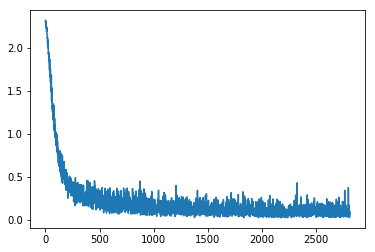

In [12]:
plt.plot(history);

In [13]:
# Save model to disk
torch.save(net.state_dict(), "net")

In [15]:
# Load model
net = ConvNet()
net.load_state_dict(torch.load("net"))